<a href="https://colab.research.google.com/github/dhikaa2/bebas/blob/main/claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from google.colab import drive
import matplotlib.pyplot as plt
from PIL import Image
import shutil
import random

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 1. Ekstrak Dataset dari Google Drive
def extract_dataset():
    # Path ke file zip di Google Drive - sesuaikan dengan lokasi di drive Anda
    zip_path = '/content/drive/MyDrive/dataset/dataset.zip'
    extract_path = '/content/dataset'

    # Hapus folder lama jika ada
    if os.path.exists(extract_path):
        shutil.rmtree(extract_path)

    # Buat folder baru dan ekstrak
    os.makedirs(extract_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

    # Cari folder yang berisi kelas-kelas
    base_dir = extract_path
    for root, dirs, files in os.walk(extract_path):
        if all(cls in dirs for cls in ['1ribu', '2ribu', '10ribu', '50ribu']):
            base_dir = root
            break

    print("\nStruktur folder dataset:")
    for cls in ['1ribu', '2ribu', '10ribu', '50ribu']:
        cls_path = os.path.join(base_dir, cls)
        if os.path.exists(cls_path):
            num_images = len([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
            print(f"{cls}: {num_images} gambar")
        else:
            print(f"⚠️ Folder {cls} tidak ditemukan di {base_dir}")

    return base_dir


In [6]:
# 2. Parameter dan Kelas
CLASS_NAMES = ['1ribu', '2ribu', '10ribu', '50ribu']
IMG_SIZE = (224, 224)  # Ukuran standar untuk model pre-trained
BATCH_SIZE = 32
EPOCHS = 50  # Lebih banyak epoch dengan early stopping
INITIAL_LR = 0.0001  # Learning rate lebih kecil untuk transfer learning

In [7]:
# 3. Persiapan Data Generator dengan Handling orientasi gambar
def prepare_data_generators(base_dir):
    # Verifikasi folder kelas
    print("\nMemverifikasi folder kelas:")
    class_counts = {}
    missing_classes = []

    for cls in CLASS_NAMES:
        cls_dir = os.path.join(base_dir, cls)
        if not os.path.exists(cls_dir):
            missing_classes.append(cls)
            continue

        images = [f for f in os.listdir(cls_dir)
                 if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))]
        class_counts[cls] = len(images)
        print(f"{cls}: {len(images)} gambar")

    if missing_classes:
        raise ValueError(f"Folder kelas berikut tidak ditemukan: {missing_classes}")

    # Buat folder train, val, test
    train_dir = os.path.join(base_dir, 'train')
    val_dir = os.path.join(base_dir, 'validation')
    test_dir = os.path.join(base_dir, 'test')

    for dir_path in [train_dir, val_dir, test_dir]:
        if os.path.exists(dir_path):
            shutil.rmtree(dir_path)
        os.makedirs(dir_path)
        for cls in CLASS_NAMES:
            os.makedirs(os.path.join(dir_path, cls), exist_ok=True)

    # Split dataset (70% train, 15% val, 15% test)
    print("\nMembagi dataset:")
    for cls in CLASS_NAMES:
        src_dir = os.path.join(base_dir, cls)
        files = [f for f in os.listdir(src_dir)
                if os.path.isfile(os.path.join(src_dir, f))]

        random.shuffle(files)
        train_split = int(0.7 * len(files))
        val_split = int(0.85 * len(files))

        for i, filename in enumerate(files):
            src_path = os.path.join(src_dir, filename)
            if i < train_split:
                dst_dir = os.path.join(train_dir, cls)
            elif i < val_split:
                dst_dir = os.path.join(val_dir, cls)
            else:
                dst_dir = os.path.join(test_dir, cls)

            shutil.copy2(src_path, os.path.join(dst_dir, filename))

        print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} train, "
              f"{len(os.listdir(os.path.join(val_dir, cls)))} val, "
              f"{len(os.listdir(os.path.join(test_dir, cls)))} test")

    # Augmentasi data untuk handle orientasi vertikal/horizontal & variasi lainnya
    train_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        rotation_range=360,  # Rotasi penuh untuk handle orientasi
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,  # Handle orientasi vertikal
        brightness_range=[0.8, 1.2],
        fill_mode='nearest'
    )

    # Untuk validation dan test, hanya preprocessing sesuai model
    val_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    test_datagen = ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    # Generator untuk training
    train_gen = train_datagen.flow_from_directory(
        train_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=True
    )

    # Generator untuk validation
    val_gen = val_datagen.flow_from_directory(
        val_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=False
    )

    # Generator untuk test
    test_gen = test_datagen.flow_from_directory(
        test_dir,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        classes=CLASS_NAMES,
        shuffle=False
    )

    return train_gen, val_gen, test_gen, class_counts

In [8]:
# 4. Bangun Model Transfer Learning dengan MobileNetV2
def build_transfer_model():
    # Load model dasar MobileNetV2 (tanpa include_top)
    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=IMG_SIZE + (3,)
    )

    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Bangun model dengan base model + custom head
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),

        # Hidden layer pertama
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.4),

        # Output layer
        layers.Dense(len(CLASS_NAMES), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LR),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model, base_model

In [9]:
# 5. Callback untuk Target Akurasi 80-90%
class TargetAccuracyCallback(callbacks.Callback):
    def __init__(self, target_min=0.8, target_max=0.9):
        super(TargetAccuracyCallback, self).__init__()
        self.target_min = target_min
        self.target_max = target_max
        self.best_weights = None
        self.best_acc = 0

    def on_epoch_end(self, epoch, logs=None):
        current_val_acc = logs.get('val_accuracy')

        # Simpan model terbaik dalam target range
        if self.target_min <= current_val_acc <= self.target_max and current_val_acc > self.best_acc:
            self.best_acc = current_val_acc
            self.best_weights = self.model.get_weights()
            print(f"\nModel terbaik diperbarui (val_acc: {current_val_acc:.4f})")

        # Warning jika akurasi di luar target
        if current_val_acc < self.target_min:
            print(f"\n⚠️ Warning: Val accuracy {current_val_acc:.4f} < target {self.target_min:.1%}")
        elif current_val_acc > self.target_max:
            print(f"\n⚠️ Warning: Val accuracy {current_val_acc:.4f} > target {self.target_max:.1%} (potential overfitting)")

    def on_train_end(self, logs=None):
        if self.best_weights is not None:
            self.model.set_weights(self.best_weights)
            print(f"\nMenggunakan model terbaik dengan val_acc: {self.best_acc:.4f}")


In [10]:
# 6. Fine-tuning Model
def unfreeze_and_finetune(model, base_model, train_gen, val_gen, class_weights):
    print("\nMemulai fine-tuning...")
    # Unfreeze beberapa layer terakhir dari base model
    for layer in base_model.layers[-30:]:  # Unfreeze 30 layer terakhir
        layer.trainable = True

    # Recompile dengan learning rate lebih kecil
    model.compile(
        optimizer=Adam(learning_rate=INITIAL_LR/10),  # LR lebih kecil untuk fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    # Fine-tuning callbacks
    finetune_callbacks = [
        TargetAccuracyCallback(target_min=0.8, target_max=0.9),
        callbacks.ModelCheckpoint(
            '/content/drive/MyDrive/best_finetuned_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=15,
            min_delta=0.001,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-7
        )
    ]

    # Fine-tuning
    finetune_history = model.fit(
        train_gen,
        epochs=25,  # Epoch lebih sedikit untuk fine-tuning
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=finetune_callbacks,
        verbose=1
    )

    return model, finetune_history

=== MEMULAI PROSES TRAINING DENGAN TRANSFER LEARNING ===

1. Mengekstrak dataset...

Struktur folder dataset:
1ribu: 302 gambar
2ribu: 311 gambar
10ribu: 284 gambar
50ribu: 300 gambar

2. Mempersiapkan data...

Memverifikasi folder kelas:
1ribu: 302 gambar
2ribu: 311 gambar
10ribu: 284 gambar
50ribu: 300 gambar

Membagi dataset:
1ribu: 211 train, 45 val, 46 test
2ribu: 217 train, 47 val, 47 test
10ribu: 198 train, 43 val, 43 test
50ribu: 210 train, 45 val, 45 test
Found 836 images belonging to 4 classes.
Found 180 images belonging to 4 classes.
Found 181 images belonging to 4 classes.

3. Menghitung class weights untuk handle imbalance data...
Class weights:
1ribu: 0.99
2ribu: 0.96
10ribu: 1.06
50ribu: 1.00

4. Membangun model transfer learning...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,593,092 (9.89 MB)

 Trainable params: 332,036 (1.27 MB)

 Non-trainable params: 2,261,056 (8.63 MB)


5. Menyiapkan callbacks...

6. Tahap 1: Training head model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.3435 - loss: 1.8340


⚠️ Warning: Val accuracy 0.4722 < target 80.0%
27/27 ━━━━━━━━━━━━━━━━━━━━ 122s 4s/step - accuracy: 0.3455 - loss: 1.8258 - val_accuracy: 0.4722 - val_loss: 1.2196 - learning_rate: 1.0000e-04
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5585 - loss: 1.0580


⚠️ Warning: Val accuracy 0.6389 < target 80.0%
27/27 ━━━━━━━━━━━━━━━━━━━━ 129s 4s/step - accuracy: 0.5598 - loss: 1.0549 - val_accuracy: 0.6389 - val_loss: 0.8704 - learning_rate: 1.0000e-04
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6924 - loss: 0.7765


⚠️ Warning: Val accuracy 0.7333 < target 80.0%
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.6925 - loss: 0.7759 - val_accuracy: 0.7333 - val_loss: 0.6876 - learning_rate: 1.0000e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7594 - loss: 0.6095


⚠️ Warning: Val accuracy 0.7556 < target 80.0%
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.7595 - loss: 0.6092 - val_accuracy: 0.7556 - val_loss: 0.5785 - learning_rate: 1.0000e-04
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7435 - loss: 0.5824


⚠️ Warning: Val accuracy 0.7889 < target 80.0%
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.7445 - loss: 0.5805 - val_accuracy: 0.7889 - val_loss: 0.5281 - learning_rate: 1.0000e-04
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7989 - loss: 0.5017


Model terbaik diperbarui (val_acc: 0.8111)
27/27 ━━━━━━━━━━━━━━━━━━━━ 105s 4s/step - accuracy: 0.7999 - loss: 0.4999 - val_accuracy: 0.8111 - val_loss: 0.4735 - learning_rate: 1.0000e-04
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.8065 - loss: 0.4394 - val_accuracy: 0.8111 - val_loss: 0.4506 - learning_rate: 1.0000e-04
Epoch 8/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8335 - loss: 0.3701


Model terbaik diperbarui (val_acc: 0.8278)
27/27 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - accuracy: 0.8333 - loss: 0.3713 - val_accuracy: 0.8278 - val_loss: 0.4315 - learning_rate: 1.0000e-04
Epoch 9/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8241 - loss: 0.4243


Model terbaik diperbarui (val_acc: 0.8500)
27/27 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.8244 - loss: 0.4243 - val_accuracy: 0.8500 - val_loss: 0.4163 - learning_rate: 1.0000e-04
Epoch 10/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8871 - loss: 0.3358


Model terbaik diperbarui (val_acc: 0.8556)
27/27 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - accuracy: 0.8865 - loss: 0.3360 - val_accuracy: 0.8556 - val_loss: 0.3894 - learning_rate: 1.0000e-04

Menggunakan model terbaik dengan val_acc: 0.8556

7. Tahap 2: Fine-tuning model...

Memulai fine-tuning...
Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7852 - loss: 0.5788


Model terbaik diperbarui (val_acc: 0.8444)
27/27 ━━━━━━━━━━━━━━━━━━━━ 128s 4s/step - accuracy: 0.7857 - loss: 0.5768 - val_accuracy: 0.8444 - val_loss: 0.3889 - learning_rate: 1.0000e-05
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 119s 4s/step - accuracy: 0.7957 - loss: 0.4639 - val_accuracy: 0.8444 - val_loss: 0.3994 - learning_rate: 1.0000e-05
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.8248 - loss: 0.4628 - val_accuracy: 0.8333 - val_loss: 0.4096 - learning_rate: 1.0000e-05
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 100s 4s/step - accuracy: 0.8058 - loss: 0.4819 - val_accuracy: 0.8222 - val_loss: 0.4240 - learning_rate: 1.0000e-05
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8100 - loss: 0.5385 - val_accuracy: 0.8222 - val_loss: 0.4318 - learning_rate: 5.0000e-06
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8629 - loss: 0.3701 - val_accuracy: 0.8222 - val_loss: 0.4397 - learning_rate: 5.0000e-06
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 92


Model terbaik diperbarui (val_acc: 0.8500)
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 4s/step - accuracy: 0.8635 - loss: 0.3527 - val_accuracy: 0.8500 - val_loss: 0.4248 - learning_rate: 6.2500e-07
Epoch 16/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8587 - loss: 0.3416 - val_accuracy: 0.8500 - val_loss: 0.4192 - learning_rate: 6.2500e-07
Epoch 17/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8686 - loss: 0.3367


Model terbaik diperbarui (val_acc: 0.8556)
27/27 ━━━━━━━━━━━━━━━━━━━━ 101s 4s/step - accuracy: 0.8687 - loss: 0.3367 - val_accuracy: 0.8556 - val_loss: 0.4144 - learning_rate: 3.1250e-07
Epoch 18/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8673 - loss: 0.3372


Model terbaik diperbarui (val_acc: 0.8611)
27/27 ━━━━━━━━━━━━━━━━━━━━ 95s 3s/step - accuracy: 0.8670 - loss: 0.3376 - val_accuracy: 0.8611 - val_loss: 0.4105 - learning_rate: 3.1250e-07
Epoch 19/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8822 - loss: 0.3102 - val_accuracy: 0.8611 - val_loss: 0.4066 - learning_rate: 3.1250e-07
Epoch 20/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8468 - loss: 0.3811 - val_accuracy: 0.8611 - val_loss: 0.4020 - learning_rate: 1.5625e-07
Epoch 21/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - accuracy: 0.8502 - loss: 0.3607 - val_accuracy: 0.8611 - val_loss: 0.3983 - learning_rate: 1.5625e-07
Epoch 22/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 96s 4s/step - accuracy: 0.8428 - loss: 0.4171 - val_accuracy: 0.8611 - val_loss: 0.3953 - learning_rate: 1.5625e-07
Epoch 23/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8591 - loss: 0.3706


Model terbaik diperbarui (val_acc: 0.8667)
27/27 ━━━━━━━━━━━━━━━━━━━━ 93s 3s/step - accuracy: 0.8593 - loss: 0.3701 - val_accuracy: 0.8667 - val_loss: 0.3932 - learning_rate: 1.0000e-07
Epoch 24/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 147s 4s/step - accuracy: 0.8873 - loss: 0.3276 - val_accuracy: 0.8667 - val_loss: 0.3929 - learning_rate: 1.0000e-07
Epoch 25/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 97s 4s/step - accuracy: 0.8659 - loss: 0.3602 - val_accuracy: 0.8667 - val_loss: 0.3926 - learning_rate: 1.0000e-07

Menggunakan model terbaik dengan val_acc: 0.8667

8. Evaluasi model...
6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.8364 - loss: 0.4076

Akurasi Test: 86.19%

✅ Model mencapai target akurasi: 86.19%!

9. Membuat visualisasi...


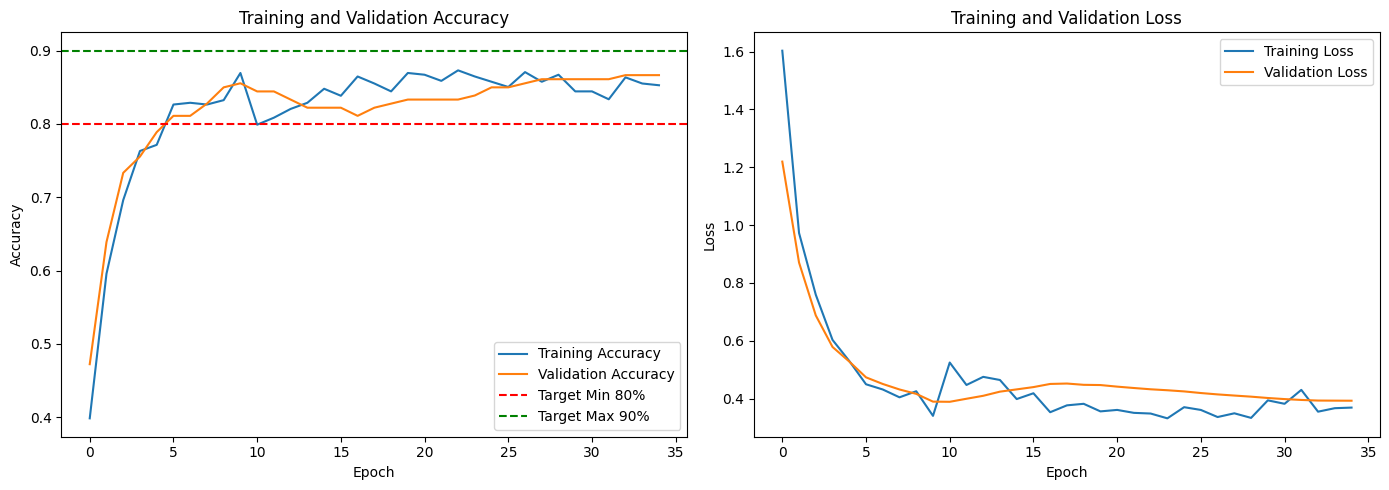


10. Membuat confusion matrix...
5/6 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step

6/6 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step


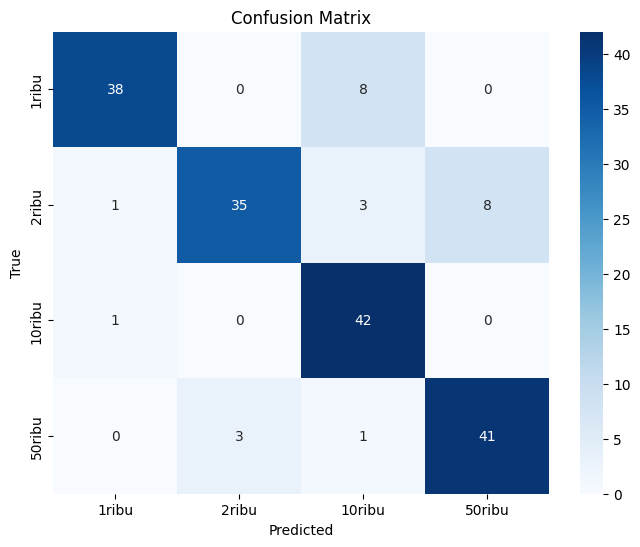


Classification Report:
              precision    recall  f1-score   support

       1ribu       0.95      0.83      0.88        46
       2ribu       0.92      0.74      0.82        47
      10ribu       0.78      0.98      0.87        43
      50ribu       0.84      0.91      0.87        45

    accuracy                           0.86       181
   macro avg       0.87      0.86      0.86       181
weighted avg       0.87      0.86      0.86       181


Model disimpan ke: /content/drive/MyDrive/currency_model_final.h5

=== TRAINING SELESAI ===
Gunakan fungsi berikut untuk prediksi:
predict_currency('/path/to/image.jpg')


In [11]:
# 7. Main Execution
try:
    print("=== MEMULAI PROSES TRAINING DENGAN TRANSFER LEARNING ===")

    # Ekstrak dataset
    print("\n1. Mengekstrak dataset...")
    dataset_dir = extract_dataset()

    # Persiapkan data
    print("\n2. Mempersiapkan data...")
    train_gen, val_gen, test_gen, class_counts = prepare_data_generators(dataset_dir)

    # Hitung class weights
    print("\n3. Menghitung class weights untuk handle imbalance data...")
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_gen.classes),
        y=train_gen.classes
    )
    class_weights = dict(enumerate(class_weights))
    print("Class weights:")
    for i, cls in enumerate(CLASS_NAMES):
        print(f"{cls}: {class_weights[i]:.2f}")

    # Bangun model transfer learning
    print("\n4. Membangun model transfer learning...")
    model, base_model = build_transfer_model()
    model.summary()

    # Callbacks
    print("\n5. Menyiapkan callbacks...")
    callbacks_list = [
        TargetAccuracyCallback(target_min=0.8, target_max=0.9),
        callbacks.ModelCheckpoint(
            '/content/drive/MyDrive/best_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            mode='max'
        ),
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            min_delta=0.001,
            mode='max'
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            min_lr=1e-6
        )
    ]

    # Training transfer learning (hanya head model)
    print("\n6. Tahap 1: Training head model...")
    history = model.fit(
        train_gen,
        epochs=10,  # Training awal sebelum fine-tuning
        validation_data=val_gen,
        class_weight=class_weights,
        callbacks=callbacks_list,
        verbose=1
    )

    # Fine-tuning
    print("\n7. Tahap 2: Fine-tuning model...")
    model, ft_history = unfreeze_and_finetune(model, base_model, train_gen, val_gen, class_weights)

    # Gabungkan history
    full_history = {}
    for k in history.history.keys():
        full_history[k] = history.history[k] + ft_history.history[k]

    # Evaluasi
    print("\n8. Evaluasi model...")
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"\nAkurasi Test: {test_acc:.2%}")

    if test_acc < 0.8:
        print("\n⚠️ Akurasi di bawah target 80%! Rekomendasi:")
        print("- Tambahkan lebih banyak data training")
        print("- Periksa kualitas gambar")
        print("- Coba model pre-trained lain seperti EfficientNet")
    elif test_acc > 0.9:
        print("\n⚠️ Akurasi di atas 90% - potensi overfitting!")
        print("- Pertimbangkan untuk menambah regularisasi")
        print("- Kurangi kompleksitas model")
    else:
        print(f"\n✅ Model mencapai target akurasi: {test_acc:.2%}!")

    # Visualisasi hasil
    print("\n9. Membuat visualisasi...")
    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(full_history['accuracy'], label='Training Accuracy')
    plt.plot(full_history['val_accuracy'], label='Validation Accuracy')
    plt.axhline(y=0.8, color='r', linestyle='--', label='Target Min 80%')
    plt.axhline(y=0.9, color='g', linestyle='--', label='Target Max 90%')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(full_history['loss'], label='Training Loss')
    plt.plot(full_history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/training_history.png')
    plt.show()

    # Confusion Matrix
    print("\n10. Membuat confusion matrix...")
    test_gen.reset()
    preds = model.predict(test_gen)
    pred_classes = np.argmax(preds, axis=1)

    cm = confusion_matrix(test_gen.classes, pred_classes)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=CLASS_NAMES,
                yticklabels=CLASS_NAMES)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig('/content/drive/MyDrive/confusion_matrix.png')
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(test_gen.classes, pred_classes, target_names=CLASS_NAMES))

    # Simpan model
    model_path = '/content/drive/MyDrive/currency_model_final.h5'
    model.save(model_path)
    print(f"\nModel disimpan ke: {model_path}")

    # Fungsi Prediksi
    def predict_currency(image_path):
        try:
            img = Image.open(image_path).convert('RGB')
            img = img.resize(IMG_SIZE)

            # Preprocess sesuai dengan model MobileNetV2
            img_array = tf.keras.applications.mobilenet_v2.preprocess_input(
                tf.keras.utils.img_to_array(img)
            )
            img_array = np.expand_dims(img_array, axis=0)

            pred = model.predict(img_array)
            class_idx = np.argmax(pred[0])
            confidence = pred[0][class_idx]
            class_name = CLASS_NAMES[class_idx]

            # Tampilkan gambar dan hasil prediksi
            plt.figure(figsize=(6,6))
            plt.imshow(img)
            plt.title(f"Predicted: {class_name}\nConfidence: {confidence:.2%}")
            plt.axis('off')
            plt.show()

            return class_name, confidence

        except Exception as e:
            print(f"Error memproses gambar: {str(e)}")
            return None, None

    print("\n=== TRAINING SELESAI ===")
    print("Gunakan fungsi berikut untuk prediksi:")
    print("predict_currency('/path/to/image.jpg')")

except Exception as e:
    print(f"\n⚠️ ERROR: {str(e)}")
    print("\nPastikan:")
    print("1. File dataset.zip ada di Google Drive di path /content/drive/MyDrive/dataset/dataset.zip")
    print("2. Struktur folder dalam zip:")
    print("   dataset.zip")
    print("   ├── 1ribu/")
    print("   ├── 2ribu/")
    print("   ├── 10ribu/")
    print("   └── 50ribu/")
    print("3. Setiap folder kelas berisi gambar (minimal 10 gambar)")

Saving IMG_20250417_225911_TIMEBURST28.jpg to IMG_20250417_225911_TIMEBURST28.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


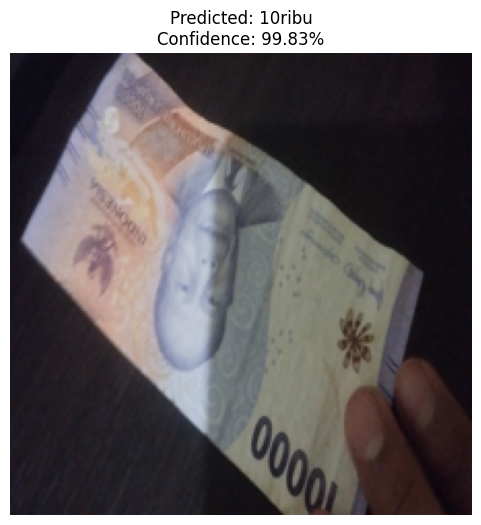

('10ribu', np.float32(0.9982937))

In [13]:
from google.colab import files
uploaded = files.upload()

# Ambil nama file yang di-upload
filename = list(uploaded.keys())[0]

# Jalankan prediksi
predict_currency(filename)
